# Data Wrangling

- 지도학습(supervised machine learning)모델을 학습하기 위한 훈련 데이터 생성 합니다.
- 지도학습을 위한 데이터 엔지니어링 방법을 이해하고 올바른 특성을 만들어 낼 수 있습니다.


데이터 랭글링(wrangling)은 분석을 하거나 모델을 만들기 전에 데이터를 사용하기 쉽게 변형하거나 맵핑하는 과정입니다. 보통 모델링 과정 중 가장 많은 시간이 소요되는 단계로 볼 수 있습니다.

이번 모듈에서는 Instacart Orders 오픈소스 데이터를 사용해 모델 학습에 사용할 수 있는 데이터세트를 만드는 과정을 심도있게 살펴보겠습니다.
- [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

다음 영상을 시청해 주세요!
- [When should I use a "groupby" in pandas?](https://youtu.be/qy0fDqoMJx8)

In [2]:
# 파일다운로드 함수
# !pip install tqdm
import requests
from tqdm.notebook import tqdm

def download_file(url):
    filename = url.split('/')[-1]    
    chunkSize = 1024
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        pbar = tqdm(unit="KB", total=int(r.headers['Content-Length']))
        for chunk in r.iter_content(chunk_size=chunkSize):
            if chunk:
                pbar.update(len(chunk))
                f.write(chunk)

In [3]:
# 처음 다운로드 받을 때 실행
download_file('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/instacart/instacart.zip')

  0%|          | 0/205791002 [00:00<?, ?KB/s]

In [4]:
# 압축을 해제합니다.
import zipfile

with zipfile.ZipFile('instacart.zip','r') as zip_ref:
    zip_ref.extractall()

In [5]:
# 압축해제 후 만들어진 폴더로 이동합니다.
%cd instacart

/content/instacart


In [6]:
# csv 파일들을 프린트합니다
from glob import glob
for filename in glob('*.csv'):
    print(filename)

departments.csv
order_products__prior.csv
orders.csv
products.csv
sample_submission.csv
order_products__train.csv
aisles.csv


In [7]:
# 각 파일의 shape, head를 출력하는 함수
from IPython.display import display
import pandas as pd

def preview():
    for filename in glob('*.csv'):
        df = pd.read_csv(filename)
        print(filename, df.shape)
        display(df.head())
        print('\n')

In [8]:
preview()

departments.csv (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol




order_products__prior.csv (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0




orders.csv (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0




products.csv (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13




sample_submission.csv (75000, 2)


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259




order_products__train.csv (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1




aisles.csv (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


- order_products_prior: `order_id`, product_id
- order_products_train: `order_id`, product_id

- orders: `order_id`, user_id

- products: product_id, aisle_id, department_id
    - departments: department_id
    - aisles: aisle_id

- sample_submission: order_id

## 기존 예측 문제에 대해 확인해 봅시다.
고객이 다음 주문에서 어떤 제품을 주문할지 예측하는 문제입니다.

[The Kaggle competition](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

- orders.csv 파일에는 eval_set 열에서 각 주문이 어떤 세트 (prior, train, test) 인지 정보를 제공합니다.

- submission 파일(테스트 정보)에는 각 order_id 마다 재구매가 예상되는 product_id 가 열거되어야 합니다.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

#### 데이터 파일들을 불러오겠습니다.

In [9]:
import numpy as np
import pandas as pd
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
submission = pd.read_csv('sample_submission.csv')


#### 데이터 파일들에 대한 설명입니다.
From [jeremystan](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

- orders (3.4m rows, 206k users):
    - order_id: order identifier
    - user_id: customer identifier
    - eval_set: which evaluation set this order belongs in (see SET described below)
    - order_number: the order sequence number for this user (1 = first, n = nth)
    - order_dow: the day of the week the order was placed on
    - order_hour_of_day: the hour of the day the order was placed on
    - days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

- products (50k rows):
    - product_id: product identifier
    - product_name: name of the product
    - aisle_id: foreign key
    - department_id: foreign key

- aisles (134 rows):
    - aisle_id: aisle identifier
    - aisle: the name of the aisle

- deptartments (21 rows):
    - department_id: department identifier
    - department: the name of the department

- order_products__SET (30m+ rows):
    - order_id: foreign key
    - product_id: foreign key
    - add_to_cart_order: order in which each product was added to cart
    - reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

- where SET is one of the four following evaluation sets (eval_set in orders):
    - "prior": orders prior to that users most recent order (~3.2m orders)
    - "train": training data supplied to participants (~131k orders)
    - "test": test data reserved for machine learning competitions (~75k orders)

#### orders 데이터형태를 살펴보세요

In [10]:
orders.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [11]:
prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [12]:
train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [13]:
submission.head(3)

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259


In [14]:
orders[orders['order_id'] == 17]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0


In [15]:
orders[orders['user_id'] == 36855]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611288,898818,36855,prior,1,1,13,NaN
611289,234692,36855,prior,2,0,9,30.0
611290,3248434,36855,prior,3,6,14,6.0
611291,1058761,36855,prior,4,5,13,6.0
611292,17,36855,test,5,6,15,1.0


In [16]:
prior[prior.order_id == 3248434]

,order_id,product_id,add_to_cart_order,reordered
30795642,3248434,15613,1,0
30795643,3248434,44056,2,0
30795644,3248434,38777,3,1
30795645,3248434,13107,4,1
30795646,3248434,18288,5,0
30795647,3248434,16965,6,0
30795648,3248434,21463,7,0
30795649,3248434,40002,8,0
30795650,3248434,6291,9,0


#### 데이터프레임 간 관계를 살펴봅시다.

모든 고객의 연속적인 구매 정보(order_id, user_id 등)가 orders에 모두 존재하고
prior, train에는 order_id와 연결된 product 정보(product_id, 카트에 넣은 순서, 재구매여부)가 존재합니다.

test(submission)의 경우 order_id만 있고 product_id 가 없습니다.

#### `orders['eval_set'] == test` or `train` 세트가 완전히 분리되어 있는지 확인합니다.
테스트고객이 훈련데이터에 포함되는 경우는 없습니다.

In [17]:
# set1.isdisjoint(set2)
set(orders[orders['eval_set']=='test']['user_id'])\
    .isdisjoint(set(orders[orders['eval_set']=='train']['user_id']))

True

#### 테스트, 훈련세트에서 각 고객에 대한 중복 샘플이 있는지 확인합니다.
한 고객은 한 샘플만 있는것으로 확인됩니다.

In [18]:
len(orders[orders['eval_set'].isin(['train','test'])]) \
,len(orders[orders['eval_set'].isin(['train','test'])]['user_id'].unique())

(206209, 206209)

원래 주어진 예측 문제는,

고객이 지금까지 구매한 연속 상품구매정보(prior)가 특성들이 되고 이 정보를 바탕으로 앞으로 구매할 제품들을 예측하는 문제입니다.

여기서 어떤 고객들의 최근 구매 product_id는 학습을 위한 타겟 특성이 되고 어떤 고객들은 이 타겟정보가 주어지지 않은 상태로 테스트 데이터가 됩니다.


## 예측 문제를 정의하기 위해 데이터를 분석해 보겠습니다.

기존 문제인 고객들마다 어떤 상품들이 재구매 될 것인지? 예측하는 문제보다 조금 더 간단한 문제를 만들고 싶습니다. 그래서 **구매자가 특정 상품을 구매 할 것인지 말 것인지(Binary classification)?** 예측하는 문제로 바꾸기 위한 데이터를 준비해 보겠습니다.

특정 상품은 데이터가 많을 수록 좋을것이기 때문에, 지금까지 가장 고객들이 많이 구입한 제품으로 정하면 좋을 것 같습니다.

앞으로 다음과 같은 질문에 대한 답을 찾는 과정에서 데이터를 만들어 보겠습니다.
1. 고객들이 가장 빈번하게 주문하는 제품은?
2. 고객들이 이 제품을 최근에 얼마나 구매를 하는지?
3. 어떤 고객들이 이 제품을 이전에(prior) 구매했었는지?
4. 이 제품을 구입한 이력이 있는 고객 데이터세트는?
5. 어떤 특성을 엔지니어링 해야 고객이 이 제품을 재구매할 것이라 예측 할 수 있을까요?

#### 이 과정을 거쳐 최종적으로 다음과 같은 데이터를 만들 것 입니다.
```
order_id, target, feature1, feature2, ...
11111111, True,   22222222, 33333333, ...
11111112, False,  11111111, 55555555, ...
11111113, False,  23232323, 12121212, ...
```

### 1. 고객들이 가장 빈번하게 주문하는 제품은?

#### 가장 빈번하게 나타나는 product_id 를 찾겠습니다.
최빈값을 찾는 mode 함수나 value_counts을 사용할 수 있습니다.

In [19]:
prior['product_id'].mode()

0    24852
Name: product_id, dtype: int64

In [20]:
prior['product_id'].value_counts()

24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
          ...  
14756         1
20264         1
31254         1
13397         1
23624         1
Name: product_id, Length: 49677, dtype: int64

In [21]:
train['product_id'].mode()

0    24852
Name: product_id, dtype: int64

prior, train 에서 가장 많이 구매하는 제품은 모두 24852 이네요.
#### 이번에는 상위 5개 구매 제품들을 찾아 봅시다.

In [22]:
top5_products = prior['product_id'].value_counts()[:5]
top5_products

24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
Name: product_id, dtype: int64

In [23]:
top5_index = list(top5_products.index)
top5_index

[24852, 13176, 21137, 21903, 47209]

#### product_id 는 중복값이 없기 때문에 인덱스로 만들어 사용하면 편리할 것 같습니다.

In [24]:
products.set_index('product_id').loc[top5_index]

,product_name,aisle_id,department_id
product_id,,,
24852,Banana,24,4
13176,Bag of Organic Bananas,24,4
21137,Organic Strawberries,24,4
21903,Organic Baby Spinach,123,4
47209,Organic Hass Avocado,24,4


1, 2위 모두 바나나입니다!

#### prior 와 product df를 합쳐 보겠습니다.
prior, train에 product 정보가 함께 있으면 제품의 정보를 확인하기에 더 편리할 것 같습니다.

In [25]:
len(products.product_id.unique()) == len(products)

True

In [26]:
prior = prior.merge(products, on='product_id')

In [27]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [28]:
prior['product_name'].value_counts()

Banana                         472565
Bag of Organic Bananas         379450
Organic Strawberries           264683
Organic Baby Spinach           241921
Organic Hass Avocado           213584
                                ...  
Frittata, Farmer's Market           1
Fig Balsamic Vinegar                1
Punjabi Chhole, Hot Spicy           1
Molasses, Bead                      1
Flatbread Pizza All Natural         1
Name: product_name, Length: 49677, dtype: int64

train 데이터도 products와 병합해놓겠습니다.

In [29]:
train = train.merge(products, on='product_id')

In [30]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


#### (Sol 1) 고객들이 가장 빈번하게 주문하는 제품은? 바나나(product_id = 24852) 입니다!
우리가 만드는 모델의 타겟은 이 바나나의 재구매 여부를 맞추는 모델이 될 것입니다.

### 2. 고객들이 최근에 바나나를 얼마나 구매 하는지?

데이터 세트 3종류에 대해 다시 한 번 정리해 봅시다,

- 고객이 주문한 가장 최근 데이터는 'train', 'test'에 존재합니다.('prior'는 최근 주문 보다 이전 주문들 기록 입니다.)
- 'test'는 제품 레이블(product_id)이 없기 때문에 학습에 사용할 수 없습니다.(레이블은 Kaggle과 Instacart만 가지고 있습니다.) 
- 'train'은 각 행이 한 제품 이고 고객이 구매한 여러 제품이 한 order_id 내에 있습니다.

여기서 우리는 한 주문에 속하는 여러 제품을 order_id 별로 그룹화해 한 줄로 나타내고 이 주문에 바나나(product_id = 24852)가 포함되어있는지 True, False로 나타내는 새로운 이진 특성(banana)을 만들어 사용하겠습니다.

두가지 방법으로 알아보겠습니다.

#### 바나나(True), 그외제품(False)인 특성을 만듭니다

In [31]:
id_Banana = 24852

In [32]:
train['banana'] = train['product_id'] == id_Banana

이 비율은 모든 구입 제품 중 바나나 비율입니다.

In [34]:
 train['banana'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: banana, dtype: float64

주문(order_id) 별 바나나 구입 비율은 어떻게 구할까요?

#### 방법 1: apply 사용
apply 는 데이터프레임에 축(axis)을 기준으로 특정한 함수를 적용(apply)하기 위한 메소드 입니다. 

최근 주문 별로 몇 개의 제품을 구입했는지 확인하려면 다음과 같습니다. 그리고 각 주문리스트에서 바나나가 포함되었는지 확인하면 될 것 같습니다.

In [35]:
train.groupby('order_id')['product_id'].count()

order_id
1           8
36          8
38          9
96          7
98         49
           ..
3421049     6
3421056     5
3421058     8
3421063     4
3421070     3
Name: product_id, Length: 131209, dtype: int64

주문 별 구입한 제품들의 product_id를 리스트로 얻습니다.

In [36]:
train.groupby('order_id')['product_id'].apply(list)

order_id
1          [49302, 11109, 10246, 49683, 43633, 13176, 472...
36         [39612, 19660, 49235, 43086, 46620, 34497, 486...
38         [11913, 18159, 4461, 21616, 23622, 32433, 2884...
96         [20574, 30391, 40706, 25610, 27966, 24489, 39275]
98         [13176, 27966, 8859, 19731, 43654, 4357, 37664...
                                 ...                        
3421049           [34243, 17706, 26800, 33424, 17299, 40800]
3421056                    [21709, 5750, 9340, 16475, 12432]
3421058    [32650, 34466, 6244, 4347, 30316, 35578, 6858,...
3421063                         [49235, 14233, 13565, 35548]
3421070                                 [35951, 16953, 4724]
Name: product_id, Length: 131209, dtype: object

`lambda x : id_Banana in list(x)` 람다함수는 주문에 바나나가 있는 경우 True를 리턴합니다.

In [37]:
train.groupby('order_id')['product_id'].apply(lambda x : id_Banana in list(x)).value_counts(normalize=True)

False    0.857281
True     0.142719
Name: product_id, dtype: float64

#### 방법 2
apply에서 list함수를 계속 호출하는 것은 상당히 느리고 비효율적인 것 같습니다.

사실 groupby 는 유용한 메소드를 많이 가지고 있습니다.[GroupBy](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html#computations-descriptive-stats)

any를 사용하면 `banana`==True인 제품이 하나라도 있으면 True를 리턴합니다.

In [38]:
# any(): 주문(order_id) 중에서 한 번이라도 Banana 주문이 있는 경우 True
train.groupby('order_id')['banana'].any().value_counts(normalize=True)

False    0.857281
True     0.142719
Name: banana, dtype: float64

train 내에서 모든 주문(order_id) 중 바나나가 포함된 비율이 14.2719% 정도 됩니다.

#### (Sol 2) 최근 구매 주문(train)중 바나나가 포함되는 주문은? 14%

#### 이제 타겟을 사용해 학습 데이터를 만들 수 있습니다!
학습 데이터는 `df` 로 만들어 나가겠습니다.(바나나 재구매를 예측하기 위한 데이터를 만들기 위해 banana를 reorder_banana로 미리 변경하겠습니다.)

In [39]:
df = train.groupby('order_id')['banana'].any().reset_index().rename(columns={'banana':'reorder_banana'})
df

,order_id,reorder_banana
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False
...,...,...
131204,3421049,False
131205,3421056,False
131206,3421058,False
131207,3421063,False


In [40]:
df['reorder_banana'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: reorder_banana, dtype: float64

In [41]:
target = 'reorder_banana'

### 3. 어떤 고객들이 바나나를 이전에(prior) 구매했나요?

- 고객은 `user_id`로 구분합니다.
- 제품은 `product_id`로 구분합니다.

현재 이 두 아이디를 같이 가지고 있는 테이블이 없는 상황입니다. 테이블들을 조인해서 만들어 볼까요?

prior 테이블은 `order_id`, `product_id` 를 가지고 있고
orders 테이블은 `user_id`를 가지고 있습니다

In [42]:
prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16


In [43]:
orders.head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN


#### (sol 3). 어떤 고객들이 바나나를 이전에(prior) 구매했나요??
바나나를 한 번이라도 구매한 이력이 있는 user_id 를 구하겠습니다.

##### 우선 prior에서 바나나가 포함된 order_ids를 찾고 orders에서 user_ids를 구합니다.

In [44]:
order_ids = prior[prior.product_id==id_Banana]['order_id']

In [45]:
user_ids = orders[orders.order_id.isin(order_ids)]['user_id'].unique()
user_ids

array([     2,     10,     16, ..., 206196, 206202, 206209])

In [46]:
print('한 번이라도 banana를 구매한 이력(prior)이 있는 유저 수: ', len(user_ids))

한 번이라도 banana를 구매한 이력(prior)이 있는 유저 수:  73956


### 4. 바나나를 구입한 이력이 있는 고객 데이터세트는?

모델은 바나나 재구매를 예측하기 때문에 모델 입력값은 한 번이라도 바나나를 구매한 고객이 대상이 될 것입니다. prior에서 바나나 구매한 이력이 없는 고객은 입력이 될 수 없습니다.

이제 바나나를 한 번이라도 구입한 적이 있는 고객의 데이터만 남기겠습니다.

banana를 구입한 이력이 있는 고객의 주문정보로 orders 제한

In [47]:
orders.shape

(3421083, 7)

In [48]:
orders = orders[orders['user_id'].isin(user_ids)]
orders.shape

(1512975, 7)

In [49]:
order_ids = orders['order_id'].unique()

In [50]:
prior.shape

(32434489, 7)

In [51]:
prior = prior[prior['order_id'].isin(order_ids)]
prior.shape

(16534534, 7)

In [52]:
df.shape

(131209, 2)

In [53]:
df = df[df['order_id'].isin(order_ids)]
df.shape

(46964, 2)

In [54]:
df.head()

,order_id,reorder_banana
0,1,False
1,36,False
9,349,False
13,631,False
18,878,True


### 5. 어떤 특성을 엔지니어링 해야 고객이 바나나를 재구매할 것이라 예측을 할 수 있을까요?

여러가지 생각해 볼 수 있는 특성들이 있습니다!
- 고객의 주문당 평균 구입 제품의 수
- 주문한 시간
- 바나나 구매 횟수, 빈도
- 바나나 외에 다른 과일을 같이 구매 하는지
- 바나나 재구매 사이의 일수
- 최근 몇일 전에 바나나를 구매했는지?
...

우선 학습데이터에 orders 데이터를 조인하여 특성들을 추가 해 보겠습니다.

In [55]:
df = df.merge(orders)

In [56]:
df

,order_id,reorder_banana,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,False,112108,train,4,4,10,9.0
1,36,False,79431,train,23,6,18,30.0
2,349,False,156353,train,9,3,16,30.0
3,631,False,184099,train,7,3,9,30.0
4,878,True,61911,train,9,2,13,30.0
...,...,...,...,...,...,...,...,...
46959,3420812,False,193913,train,15,5,13,6.0
46960,3420895,False,20949,train,7,1,19,21.0
46961,3420909,False,8765,train,31,0,19,13.0
46962,3420996,True,15818,train,16,1,9,7.0


#### 1) 고객의 주문당 평균 구입 제품의 수

데이터 처리를 쉽게 하기 위해 prior에 orders 정보를 병합합니다.

In [57]:
prior

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
1,26,33120,5,0,Organic Egg Whites,86,16
6,582,33120,7,1,Organic Egg Whites,86,16
7,608,33120,5,1,Organic Egg Whites,86,16
11,771,33120,29,1,Organic Egg Whites,86,16
12,800,33120,3,1,Organic Egg Whites,86,16
...,...,...,...,...,...,...,...
32434477,3188686,34211,3,0,Greek Pitted Kalamata Olives,110,13
32434479,3206343,28486,2,0,Master Blend Coffee,26,7
32434481,3229668,31465,9,0,Imported Stout Draught Style,27,5
32434485,3361945,43492,19,0,Gourmet Burger Seasoning,104,13


In [58]:
prior = prior.merge(orders, how='left', on='order_id')

유저별 주문당 제품수

In [59]:
prior

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0
1,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0
2,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0
3,771,33120,29,1,Organic Egg Whites,86,16,73968,prior,16,0,17,7.0
4,800,33120,3,1,Organic Egg Whites,86,16,132856,prior,3,5,7,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534529,3188686,34211,3,0,Greek Pitted Kalamata Olives,110,13,44202,prior,2,5,16,22.0
16534530,3206343,28486,2,0,Master Blend Coffee,26,7,55598,prior,9,1,13,14.0
16534531,3229668,31465,9,0,Imported Stout Draught Style,27,5,41154,prior,5,2,15,8.0
16534532,3361945,43492,19,0,Gourmet Burger Seasoning,104,13,142932,prior,25,3,10,5.0


In [60]:
prior.groupby(['user_id','order_id']).count()

product_id  add_to_cart_order  reordered  product_name  \
user_id order_id                                                           
2       738281            13                 13         13            13   
        788338            16                 16         16            16   
        839880            16                 16         16            16   
        1199898           21                 21         21            21   
        1402090           15                 15         15            15   
...                      ...                ...        ...           ...   
206209  2307371            3                  3          3             3   
        2558525            3                  3          3             3   
        2977660            9                  9          9             9   
        3154581           13                 13         13            13   
        3186442            2                  2          2             2   

                  aisle_id  department_id  eval_set  order_number  order_dow  \
user_id order_id                                                               
2       738281          13             13        13            13         13   
        788338          16             16        16            16         16   
        839880          16             16        16            16         16   
        1199898         21             21        21            21         21   
        1402090         15             15        15            15         15   
...                    ...            ...       ...           ...        ...   
206209  2307371          3              3         3             3          3   
        2558525          3              3         3             3          3   
        2977660          9              9         9             9          9   
        3154581         13             13        13            13         13   
        3186442          2              2         2             2          2   

                  order_hour_of_day  days_since_prior_order  
user_id order_id                                             
2       738281                   13                      13  
        788338                   16                      16  
        839880                   16                      16  
        1199898                  21                      21  
        1402090                  15                      15  
...                             ...                     ...  
206209  2307371                   3                       3  
        2558525                   3                       3  
        2977660                   9                       9  
        3154581                  13                       0  
        3186442                   2                       2  

[1439019 rows x 11 columns]

In [61]:
prior.groupby(['user_id','order_id']).count().reset_index().groupby('user_id').mean()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,,,,,,,,,
2,1.787782e+06,13.928571,13.928571,13.928571,13.928571,13.928571,13.928571,13.928571,13.928571,13.928571,13.928571,13.000000
10,9.690844e+05,28.600000,28.600000,28.600000,28.600000,28.600000,28.600000,28.600000,28.600000,28.600000,28.600000,27.600000
16,1.923151e+06,11.666667,11.666667,11.666667,11.666667,11.666667,11.666667,11.666667,11.666667,11.666667,11.666667,9.166667
21,1.733388e+06,6.212121,6.212121,6.212121,6.212121,6.212121,6.212121,6.212121,6.212121,6.212121,6.212121,6.060606
27,1.708241e+06,9.481481,9.481481,9.481481,9.481481,9.481481,9.481481,9.481481,9.481481,9.481481,9.481481,9.469136
...,...,...,...,...,...,...,...,...,...,...,...,...
206194,1.682394e+06,11.545455,11.545455,11.545455,11.545455,11.545455,11.545455,11.545455,11.545455,11.545455,11.545455,9.818182
206195,1.764701e+06,3.526316,3.526316,3.526316,3.526316,3.526316,3.526316,3.526316,3.526316,3.526316,3.526316,3.421053
206196,1.649862e+06,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,17.750000


In [62]:
products_per_order = (prior
                      .groupby(['user_id','order_id'])
                      .count()
                      .reset_index()
                      .groupby('user_id')['product_id']
                      .mean()
                      .reset_index()
                      .rename(columns={'product_id':'products_per_order'}))
products_per_order

,user_id,products_per_order
0,2,13.928571
1,10,28.600000
2,16,11.666667
3,21,6.212121
4,27,9.481481
...,...,...
73951,206194,11.545455
73952,206195,3.526316
73953,206196,22.500000
73954,206202,9.000000


In [63]:
df = df.merge(products_per_order, on='user_id')

In [64]:
df.head()

,order_id,reorder_banana,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,products_per_order
0,1,False,112108,train,4,4,10,9.0,7.000000
1,36,False,79431,train,23,6,18,30.0,8.500000
2,349,False,156353,train,9,3,16,30.0,19.625000
3,631,False,184099,train,7,3,9,30.0,15.166667
4,878,True,61911,train,9,2,13,30.0,24.500000


#### 바나나 재주문 여부에 따른 평균 제품 개수에 대한 분포 차이


In [65]:
no_reorder = df[df.reorder_banana==False]['products_per_order']
reorder = df[df.reorder_banana==True]['products_per_order']

[Text(0.5, 0, 'products mean'), Text(0.5, 1.0, 'reorder')]

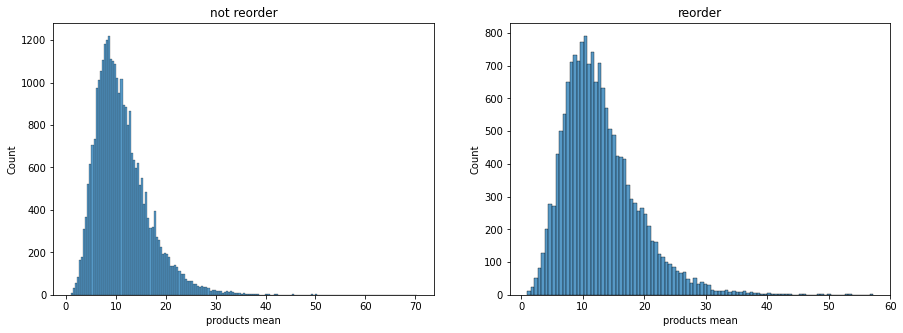

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(no_reorder, ax=ax[0]);
sns.histplot(reorder, ax=ax[1]);

ax[0].set(xlabel='products mean', title="not reorder")
ax[1].set(xlabel='products mean', title="reorder")

In [67]:
df.groupby('reorder_banana')['products_per_order'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
reorder_banana,,,,,
False,30407,11.309998,10.269231,70.25,1.0
True,16557,12.882434,11.833333,57.25,1.0


바나나 재주문한 고객의 평균 주문 제품 수가 일반적인 주문일때 보다 높은 것을 볼 수 있습니다. '주문당 제품의 수'도 새로운 특성이 될 수 있을 것 같습니다.

#### 2) 고객들이 바나나를 가장 많이 구입하는 시간?
`order_hour_of_day` 에 대해서 분포를 살펴 봅시다.

고객들이 바나나를 가장 많이 구입하는 시간은? 언제일까요? prior 에서 구해 봅시다.

In [68]:
prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0


In [69]:
hb = prior[prior.product_id==id_Banana]['order_hour_of_day'].value_counts()
hnb = prior[prior.product_id!=id_Banana]['order_hour_of_day'].value_counts()

print(hb[:3])
print(hnb[:3])

10    40731
11    38455
14    38218
Name: order_hour_of_day, dtype: int64
10    1387389
11    1353677
14    1329907
Name: order_hour_of_day, dtype: int64


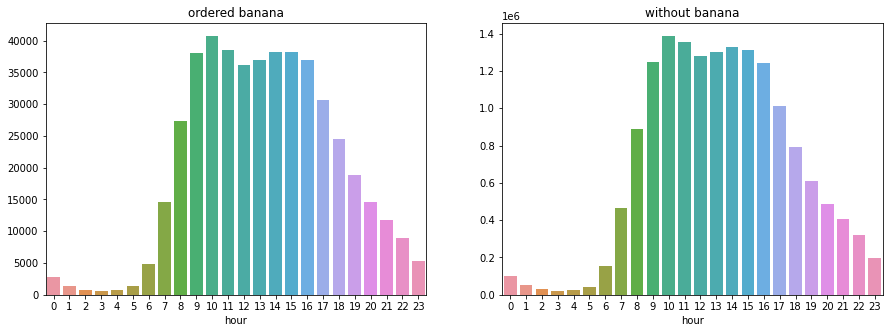

In [70]:
hb = hb.sort_index()
hnb = hnb.sort_index()

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=hb.index, y=hb.values, ax=ax[0]);
sns.barplot(x=hnb.index, y=hnb.values, ax=ax[1]);

ax[0].set(xlabel='hour', title="ordered banana")
ax[1].set(xlabel='hour', title="without banana")


sns.barplot(x=hb.index, y=hb.values);

In [71]:
print(hb.sort_values(ascending=False).index.tolist())
print(hnb.sort_values(ascending=False).index.tolist())

[10, 11, 14, 15, 9, 13, 16, 12, 17, 8, 18, 19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3]
[10, 11, 14, 15, 13, 12, 9, 16, 17, 8, 18, 19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3]


바나나 구입 시간의 분포와 순위가 약간 다르긴 하지만 크게 차이나 보이지 않습니다. 좋은 특성이 될지는 의문입니다.

#### 3) 바나나 구매 횟수

In [72]:
df

,order_id,reorder_banana,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,products_per_order
0,1,False,112108,train,4,4,10,9.0,7.000000
1,36,False,79431,train,23,6,18,30.0,8.500000
2,349,False,156353,train,9,3,16,30.0,19.625000
3,631,False,184099,train,7,3,9,30.0,15.166667
4,878,True,61911,train,9,2,13,30.0,24.500000
...,...,...,...,...,...,...,...,...,...
46959,3420812,False,193913,train,15,5,13,6.0,16.000000
46960,3420895,False,20949,train,7,1,19,21.0,18.166667
46961,3420909,False,8765,train,31,0,19,13.0,9.200000
46962,3420996,True,15818,train,16,1,9,7.0,13.733333


In [73]:
num_ordered_banana = (prior[(prior.user_id.isin(df.user_id)) & (prior.product_id==id_Banana)]
 .groupby('user_id')['product_id']
 .count()
 .reset_index()
 .rename(columns={'product_id':'num_ordered_banana'}))
num_ordered_banana

,user_id,num_ordered_banana
0,2,7
1,10,1
2,21,3
3,27,5
4,37,8
...,...,...
46959,206190,2
46960,206191,5
46961,206195,1
46962,206196,3


In [74]:
df = df.merge(num_ordered_banana,on='user_id')
df

,order_id,reorder_banana,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,products_per_order,num_ordered_banana
0,1,False,112108,train,4,4,10,9.0,7.000000,1
1,36,False,79431,train,23,6,18,30.0,8.500000,4
2,349,False,156353,train,9,3,16,30.0,19.625000,1
3,631,False,184099,train,7,3,9,30.0,15.166667,1
4,878,True,61911,train,9,2,13,30.0,24.500000,6
...,...,...,...,...,...,...,...,...,...,...
46959,3420812,False,193913,train,15,5,13,6.0,16.000000,13
46960,3420895,False,20949,train,7,1,19,21.0,18.166667,5
46961,3420909,False,8765,train,31,0,19,13.0,9.200000,1
46962,3420996,True,15818,train,16,1,9,7.0,13.733333,14


#### 4) 최근 몇일 전에 바나나를 구입했는지?
최근 주문이 언제 일어날지 모르는 상황으로 보고,

prior에서 가장 최근 바나나 구입부터 가장 최근 주문 날까지 days_since_prior_order 값을 합산

orders 에 banana 구입 주문을 표시합니다.

In [75]:
# order_ids: prior, 바나나 포함된 주문 아이디
order_ids = prior[prior.product_id==id_Banana]['order_id']

In [76]:
banana_in_order = orders[(orders.eval_set=='prior') & (orders.order_id.isin(order_ids))][['order_id']]
banana_in_order['banana_in_order'] = True
banana_in_order

,order_id,banana_in_order
14,738281,True
16,1199898,True
17,3194192,True
18,788338,True
19,1718559,True
...,...,...
3420915,1764570,True
3421078,2266710,True
3421079,1854736,True
3421080,626363,True


In [77]:
orders = orders.merge(banana_in_order,how='left',on='order_id')

In [78]:
orders['banana_in_order'].value_counts(normalize=True, dropna=False)

NaN     0.687658
True    0.312342
Name: banana_in_order, dtype: float64

In [79]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,banana_in_order
0,2168274,2,prior,1,2,11,NaN,NaN
1,1501582,2,prior,2,5,10,10.0,NaN
2,1901567,2,prior,3,1,10,3.0,NaN
3,738281,2,prior,4,2,10,8.0,True
4,1673511,2,prior,5,3,11,8.0,NaN
...,...,...,...,...,...,...,...,...
1512970,2266710,206209,prior,10,5,18,29.0,True
1512971,1854736,206209,prior,11,4,10,30.0,True
1512972,626363,206209,prior,12,1,12,18.0,True
1512973,2977660,206209,prior,13,1,12,7.0,True


In [80]:
last_banana_order_number = (orders[(orders.banana_in_order==True) & (orders.eval_set=='prior')]
                            .groupby(['user_id'])
                            .tail(n=1)[['user_id','order_number']]
                            .rename(columns={'order_number':'last_banana_order_number'}))
last_banana_order_number

,user_id,last_banana_order_number
13,2,14
15,10,1
26,16,6
48,21,21
135,27,74
...,...,...
1512911,206194,11
1512924,206195,12
1512935,206196,3
1512957,206202,20


In [81]:
orders = orders.merge(last_banana_order_number, how='left', on='user_id')

In [82]:
orders[orders.user_id==2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,banana_in_order,last_banana_order_number
0,2168274,2,prior,1,2,11,NaN,NaN,14
1,1501582,2,prior,2,5,10,10.0,NaN,14
2,1901567,2,prior,3,1,10,3.0,NaN,14
3,738281,2,prior,4,2,10,8.0,True,14
4,1673511,2,prior,5,3,11,8.0,NaN,14
5,1199898,2,prior,6,2,9,13.0,True,14
6,3194192,2,prior,7,2,12,14.0,True,14
7,788338,2,prior,8,1,15,27.0,True,14
8,1718559,2,prior,9,2,9,8.0,True,14
9,1447487,2,prior,10,1,11,6.0,True,14


In [83]:
orders_cut = orders[orders.order_number > orders.last_banana_order_number]
orders_cut

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,banana_in_order,last_banana_order_number
14,1492625,2,train,15,1,11,30.0,NaN,14
16,68288,10,prior,2,5,15,30.0,NaN,1
17,2115522,10,prior,3,3,19,12.0,NaN,1
18,83395,10,prior,4,3,15,14.0,NaN,1
19,1353310,10,prior,5,5,20,23.0,NaN,1
...,...,...,...,...,...,...,...,...,...
1512937,3383615,206196,train,5,0,15,30.0,NaN,3
1512958,1869536,206202,prior,21,4,0,30.0,NaN,20
1512959,1112560,206202,prior,22,3,14,6.0,NaN,20
1512960,2728930,206202,test,23,2,17,6.0,NaN,20


In [84]:
days_since_banana_order = (orders_cut
                                 .groupby('user_id')['days_since_prior_order']
                                 .agg('sum')
                                 .reset_index()
                                 .rename(columns={'days_since_prior_order':'days_since_banana_order'}))
days_since_banana_order

,user_id,days_since_banana_order
0,2,30.0
1,10,109.0
2,16,7.0
3,21,142.0
4,27,42.0
...,...,...
73951,206194,6.0
73952,206195,93.0
73953,206196,51.0
73954,206202,42.0


In [85]:
df = df.merge(days_since_banana_order,how='left',on='user_id')
df

,order_id,reorder_banana,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,products_per_order,num_ordered_banana,days_since_banana_order
0,1,False,112108,train,4,4,10,9.0,7.000000,1,24.0
1,36,False,79431,train,23,6,18,30.0,8.500000,4,169.0
2,349,False,156353,train,9,3,16,30.0,19.625000,1,111.0
3,631,False,184099,train,7,3,9,30.0,15.166667,1,90.0
4,878,True,61911,train,9,2,13,30.0,24.500000,6,30.0
...,...,...,...,...,...,...,...,...,...,...,...
46959,3420812,False,193913,train,15,5,13,6.0,16.000000,13,6.0
46960,3420895,False,20949,train,7,1,19,21.0,18.166667,5,21.0
46961,3420909,False,8765,train,31,0,19,13.0,9.200000,1,226.0
46962,3420996,True,15818,train,16,1,9,7.0,13.733333,14,7.0


지금까지 학습 데이터를 만들기 위해 데이터를 여러가지 방법으로 랭글링 하였습니다. 분명한 것은 원본 데이터로부터 더 좋은 특성을 가진 학습데이터를 만들어 내는 방법은 무수히 많을 수 있다는 것입니다.

이 데이터로 학습이 잘 된다면 행운이겠지만, 그렇지 않을 경우 여러분은 더 좋은 학습 데이터를 만들기 위해 알수없는 기간 고군분투 해야 할 수 있습니다!

## 참고자료

- [Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
- [GroupBy](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html#computations-descriptive-stats)
- [Group by: split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#group-by-split-apply-combine)
